In [2]:
import re
import time, random
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import sqlite3
import os
import matplotlib.pyplot as plt
import copy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import make_column_transformer
from zipfile import ZipFile
import io
from io import TextIOWrapper
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML

def get_usage_colormap():
    use_cmap = np.zeros(shape=(256,4))
    use_cmap[:,-1] = 1
    uses = np.array([
        [0, 0.00000000000, 0.00000000000, 0.00000000000],
        [11, 0.27843137255, 0.41960784314, 0.62745098039],
        [12, 0.81960784314, 0.86666666667, 0.97647058824],
        [21, 0.86666666667, 0.78823529412, 0.78823529412],
        [22, 0.84705882353, 0.57647058824, 0.50980392157],
        [23, 0.92941176471, 0.00000000000, 0.00000000000],
        [24, 0.66666666667, 0.00000000000, 0.00000000000],
        [31, 0.69803921569, 0.67843137255, 0.63921568628],
        [41, 0.40784313726, 0.66666666667, 0.38823529412],
        [42, 0.10980392157, 0.38823529412, 0.18823529412],
        [43, 0.70980392157, 0.78823529412, 0.55686274510],
        [51, 0.64705882353, 0.54901960784, 0.18823529412],
        [52, 0.80000000000, 0.72941176471, 0.48627450980],
        [71, 0.88627450980, 0.88627450980, 0.75686274510],
        [72, 0.78823529412, 0.78823529412, 0.46666666667],
        [73, 0.60000000000, 0.75686274510, 0.27843137255],
        [74, 0.46666666667, 0.67843137255, 0.57647058824],
        [81, 0.85882352941, 0.84705882353, 0.23921568628],
        [82, 0.66666666667, 0.43921568628, 0.15686274510],
        [90, 0.72941176471, 0.84705882353, 0.91764705882],
        [95, 0.43921568628, 0.63921568628, 0.72941176471],
    ])
    for row in uses:
        use_cmap[int(row[0]),:-1] = row[1:]
    return ListedColormap(use_cmap)

%matplotlib inline
plt.rcParams["font.size"] = 16
random_seed = 0

In [3]:
path = "data/images.db"
assert os.path.exists(path)
conn = sqlite3.connect(path)
df = pd.read_sql("SELECT file_name, district_name, lon, lat, water_ratio, forest_ratio, agriculture_ratio, developed_ratio FROM sample INNER JOIN districts ON sample.district_id = districts.district_id  LIMIT 400 ", conn)
train, test = train_test_split(df, random_state=0)

In [4]:
#Q1: What are the last 5 rows of the test dataset?
test.tail(5)

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio
146,area0146.npy,district 08,-87.869312,44.365150,0.0048,0.0249,0.8343,0.0896
135,area0135.npy,district 06,-87.852985,43.935362,0.0030,0.0463,0.8241,0.0697
390,area0390.npy,district 01,-88.908064,42.562049,0.0000,0.1818,0.6871,0.0763
264,area0264.npy,district 01,-87.842951,42.704875,0.0030,0.0376,0.0423,0.8906
364,area0364.npy,district 01,-87.987364,42.754155,0.0025,0.0498,0.8408,0.0689


<AxesSubplot:xlabel='forest_ratio', ylabel='developed_ratio'>

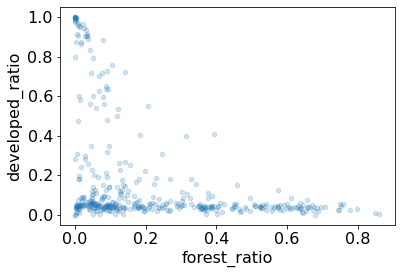

In [5]:
#Q2: What is the relationship between developed_ratio and _____? [PLOT]
df.plot.scatter(x="forest_ratio", y="developed_ratio", alpha=0.2)

In [6]:
#Q3: What are the developed_ratio predictions of a Linear model on the first 5 test points?
lr = LinearRegression()
model = lr.fit(train[['lat', 'lon', 'water_ratio', 'forest_ratio', 'agriculture_ratio']], train[["developed_ratio"]])
df_test = copy.copy(test)
df_test[['predicted']] = lr.predict(test[['lat', 'lon', 'water_ratio', 'forest_ratio', 'agriculture_ratio']])
df_test.head(5)

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio,predicted
132,area0132.npy,district 06,-87.940213,43.750300,0.0058,0.0266,0.5506,0.2990,0.187514
309,area0309.npy,district 07,-91.854009,45.352143,0.0002,0.1366,0.8074,0.0401,-0.155128
341,area0341.npy,district 01,-88.294035,42.656175,0.0010,0.3283,0.2029,0.1805,0.376093
196,area0196.npy,district 06,-89.557249,44.187877,0.0000,0.0836,0.8079,0.0412,-0.054414
246,area0246.npy,district 05,-88.596203,43.159942,0.0002,0.0201,0.6677,0.0921,0.188176


In [7]:
#Q4: How does the model score when evaluated against the test dataset?
lr.fit(df_test[['predicted']], test['developed_ratio'])
lr.score(df_test[["predicted"]], test["developed_ratio"])

0.7188339488175368

<AxesSubplot:xlabel='developed_ratio', ylabel='predicted'>

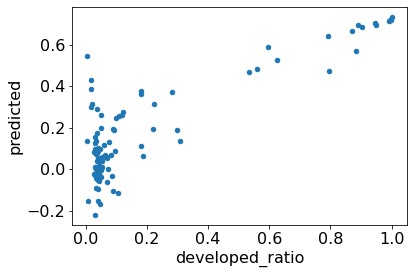

In [8]:
#Q5: How do the predictions compare to the actual values? [PLOT]
new_df = pd.DataFrame(test[['developed_ratio']])
new_df[['predicted']] = df_test[['predicted']]
new_df.plot.scatter(x='developed_ratio', y='predicted')

<AxesSubplot:>

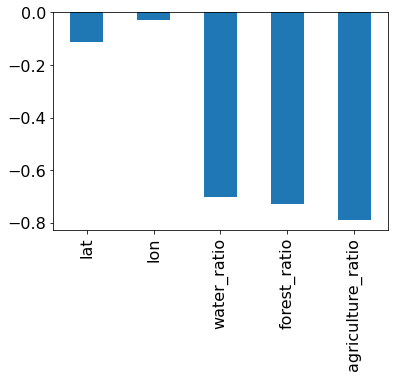

In [9]:
#Q6: What are the coefficients for each feature in your model? [PLOT]
model = lr.fit(train[['lat', 'lon', 'water_ratio', 'forest_ratio', 'agriculture_ratio']], train[["developed_ratio"]])
res = model.coef_.tolist()
new_list = []
for item in res:
    for num in item:
        new_list.append(num)
new_list
df = pd.Series(data = new_list, index = ['lat', 'lon', 'water_ratio', 'forest_ratio', 'agriculture_ratio'])
df.plot.bar()


In [10]:
#Q7: Can we beat our simple model's score of 0.756 with a more complicated model?
m2 = Pipeline([
    ("both", make_column_transformer((OneHotEncoder(), ["district_name"]), 
                                     (PolynomialFeatures(degree=2, include_bias=False), ["water_ratio", 'forest_ratio', 'agriculture_ratio']), remainder='passthrough')),
    ("lr", LinearRegression())
])
m2.fit(train[['district_name','lat', 'lon', 'water_ratio', 'forest_ratio', 'agriculture_ratio']], train['developed_ratio'])
m2.score(test[['district_name','lat', 'lon', 'water_ratio', 'forest_ratio', 'agriculture_ratio']], test["developed_ratio"])

0.8420970788505493

In [11]:
#Q8: what are the mean (average) scores for simple and complex models, respectively?
simple = lr.fit(train[['lat', 'lon', 'water_ratio', 'forest_ratio', 'agriculture_ratio']], train[["developed_ratio"]])
x = train[['lat', 'lon', 'water_ratio', 'forest_ratio', 'agriculture_ratio']]
y = train[["developed_ratio"]]
advanced = m2.fit(train[['district_name','lat', 'lon', 'water_ratio', 'forest_ratio', 'agriculture_ratio']], train['developed_ratio'])
advanced_x = train[['district_name','lat', 'lon', 'water_ratio', 'forest_ratio', 'agriculture_ratio']]
advanced_y = train['developed_ratio']
simple_cvs = cross_val_score(simple, x, y, cv=8)
simple_cvs.mean()
advanced_cvs = cross_val_score(m2,advanced_x, advanced_y, cv=8)
advanced_cvs.mean()
tuple([simple_cvs.mean(),advanced_cvs.mean()])


(0.6517545836308132, 0.7882683505969756)

In [12]:
#Q9: what is the standard deviation of scores for each model?

tuple([np.std(simple_cvs),np.std(advanced_cvs)])

(0.11307460959365212, 0.06667525211477948)

In [13]:
#Q10: How many cells in all of area1234.npy contain code 52?
with ZipFile('data/images.zip') as zf:
     with zf.open('area1234.npy') as f:
            buf = io.BytesIO(f.read())
            map_array = np.load(buf)
(map_array % 52 == 0).sum()
    

80

In [14]:
#Q11: What are the last 5 rows of the new test dataset?
big_df = pd.read_sql("SELECT file_name, district_name, lon, lat, water_ratio, forest_ratio, agriculture_ratio, developed_ratio FROM sample INNER JOIN districts ON sample.district_id = districts.district_id", conn)
row = next(big_df[big_df.isna().any(axis=1)].iterrows())


with ZipFile('data/images.zip') as zf:
    for index, row in big_df[big_df.isna().any(axis = 1)].iterrows():
        with zf.open(row['file_name']) as f:
            buf = io.BytesIO(f.read())
            map_array = np.load(buf)
            water_r = (map_array == 11).astype(int).mean()
            big_df.at[index,'water_ratio'] = water_r
            big_df.at[index,'forest_ratio'] = (map_array % 44 > 40).astype(int).mean()
            big_df.at[index,'agriculture_ratio'] = (map_array % 83 >80).astype(int).mean()
            big_df.at[index,'developed_ratio'] = (map_array % 25 > 20).astype(int).mean()

big_train, big_test = train_test_split(big_df, random_state=0)
big_test.tail(5) 

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio
936,area0936.npy,district 03,-92.152574,44.502114,0.0000,0.4248,0.5276,0.0396
1524,area1524.npy,district 02,-90.151901,43.211515,0.0002,0.1870,0.7766,0.0354
1415,area1415.npy,district 05,-88.921017,43.197963,0.0001,0.0543,0.6463,0.0307
1223,area1223.npy,district 04,-87.906383,43.074510,0.0145,0.0169,0.0060,0.9283
1548,area1548.npy,district 03,-90.359220,43.570773,0.0000,0.2854,0.6702,0.0395


In [15]:
m13 = Pipeline([
    ("both", make_column_transformer((OneHotEncoder(), ["district_name"]), 
                                     (PolynomialFeatures(degree=2, include_bias=False), ["water_ratio", 'forest_ratio', 'agriculture_ratio']), remainder='drop')),
    ("lr", LinearRegression())
])


In [16]:
#Q12: what are the mean (average) scores for simple and complex models, respectively, on the larger dataset?
m12 = LinearRegression()
simple_model = m12.fit(big_train[['lat', 'lon', 'water_ratio', 'forest_ratio', 'agriculture_ratio']], big_train[["developed_ratio"]])
x = big_train[['lat', 'lon', 'water_ratio', 'forest_ratio', 'agriculture_ratio']]
y = big_train[["developed_ratio"]]
advanced = m13.fit(big_train[['district_name','lat', 'lon', 'water_ratio', 'forest_ratio', 'agriculture_ratio']], big_train[['developed_ratio']])
advanced_x = big_train[['district_name','lat', 'lon', 'water_ratio', 'forest_ratio', 'agriculture_ratio']]
advanced_y = big_train[['developed_ratio']]
simple_cvs = cross_val_score(simple_model, x, y, cv=8)
simple_cvs.mean()
advanced_cvs = cross_val_score(m2,advanced_x, advanced_y, cv=8)
advanced_cvs.mean()
tuple([simple_cvs.mean(),advanced_cvs.mean()])

(0.7768297739753532, 0.8836935447588883)

Text(0.5, 1.0, 'Madison 2016')

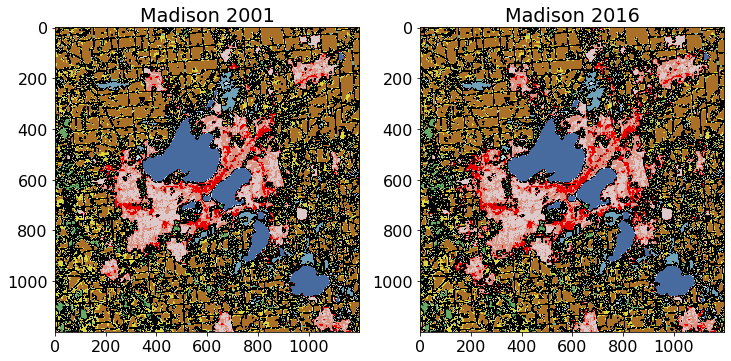

In [17]:
from matplotlib import pyplot as plt

with ZipFile("data/madison.zip") as zf:
    with zf.open("year-2001.npy") as f:
        buf = io.BytesIO(f.read())
        mad2001 = np.load(buf)
    with zf.open("year-2016.npy") as f:
        buf = io.BytesIO(f.read())
        mad2016 = np.load(buf)

fig, axes = plt.subplots(ncols=2, figsize=(12,6))
axes[0].imshow(mad2001, vmin=0, vmax=255, cmap=get_usage_colormap())
axes[0].set_title("Madison 2001")
axes[1].imshow(mad2016, vmin=0, vmax=255, cmap=get_usage_colormap())
axes[1].set_title("Madison 2016")



In [18]:
#Q13: What is the shape of the 2001 Madison matrix?
mad2001.shape

(1200, 1200)

In [19]:
#Q14: What portion of the points in Madison changed from 2001 to 2016?
(mad2001 != mad2016).astype(int).mean()

0.06156458333333333

In [20]:
#Q15: What years appear in madison.zip
year_list= []
file_list = []
with ZipFile("data/madison.zip") as zf:
    for info in zf.infolist():
        name = info.filename
        file_list.append(name)
        year = name[5:-4]
        year_list.append(int(year))
year_list 

[2001, 2004, 2006, 2008, 2011, 2013, 2016]

In [21]:
conn.close()